In [1]:
import numpy as np
import pandas as pd
import os
import glob

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report, average_precision_score

from xgboost import XGBRegressor
import matplotlib.pyplot as plt 
import xgboost
import transferboost as tb
from transferboost.dataset import load_data
import warnings
warnings.filterwarnings('ignore')
from transferboost.models import XGBTransferLearner
from transferboost.models import LGBMTransferLearner
import lightgbm as lgb
from lightgbm import LGBMClassifier
%matplotlib inline
import seaborn as sns
import natsort as ns
from sklearn.model_selection import RepeatedStratifiedKFold
import yellowbrick
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import statistics
from matplotlib import pyplot
from matplotlib import ticker
from scipy import interp

In [2]:
#Open csv and save to pickle
# df = pd.read_csv('/Users/marnixtimmermans/Desktop/Thesis/archive/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv')
# df.to_pickle("LendingClub.pkl")

In [3]:
#Open pickle and save to dataframe
df = pd.read_pickle("LendingClub.pkl")
len(df)

2260701

In [4]:
pd.value_counts(df.loan_status).to_frame().reset_index()

,index,loan_status
0,Fully Paid,1076751
1,Current,878317
2,Charged Off,268559
3,Late (31-120 days),21467
4,In Grace Period,8436
5,Late (16-30 days),4349
6,Does not meet the credit policy. Status:Fully ...,1988
7,Does not meet the credit policy. Status:Charge...,761
8,Default,40


# Classify loans as 'good' or 'bad and print bad loan rate'

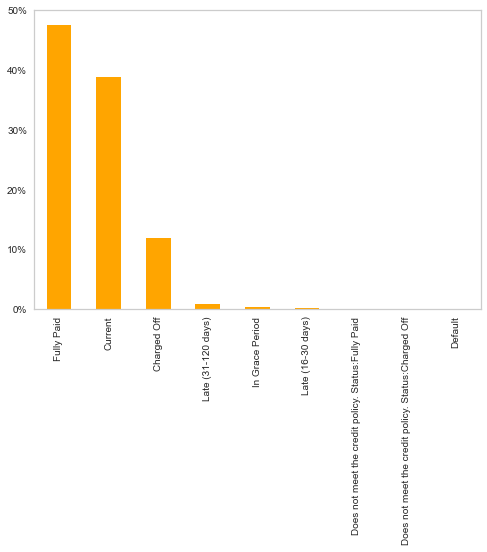

In [5]:
# df.groupby('loan_status').size().plot.bar()
ax = df['loan_status'].value_counts(normalize=True).plot.bar(color='orange')
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))  
plt.grid(False)
# plt.savefig('Chart.png')

In [6]:
#Erase fully paid loans
df = df[df.loan_status != 'Does not meet the credit policy. Status:Fully Paid']
df = df[df.loan_status != 'Does not meet the credit policy. Status:Charged Off']

In [7]:
#Assign 1 or 0 to good and bad loans 
df['rating'] = np.where((df.loan_status != 'Fully Paid') & (df.loan_status != 'Current') & (df.loan_status != 'Late (16-30 days)') & (df.loan_status != 'In Grace Period'), 1, 0)
pd.value_counts(df.rating).to_frame()

,rating
0,1967853
1,290099


In [8]:
print ('Bad Loan Ratio: %.2f%%'  % (df.rating.sum()/len(df)*100))

Bad Loan Ratio: 12.85%


In [9]:
#Show DataFrame full
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
# pd.set_option('display.max_colwidth', None)  # or 199

# Erase column if more than 20% NaN Values

In [10]:
#Erase column if more than 1000 NaNs
df.isnull().sum(axis = 0)
print (df.isnull().mean() * 100)
print('Columns before erasing NaN columns', (len(df.columns)))
df = df.loc[:, df.isnull().mean() <= .2]
print('Columns after erasing NaN columns', (len(df.columns)))

id                                              0.000000
member_id                                     100.000000
loan_amnt                                       0.001462
funded_amnt                                     0.001462
funded_amnt_inv                                 0.001462
term                                            0.001462
int_rate                                        0.001462
installment                                     0.001462
grade                                           0.001462
sub_grade                                       0.001462
emp_title                                       7.389130
emp_length                                      6.506161
home_ownership                                  0.001462
annual_inc                                      0.001462
verification_status                             0.001462
issue_d                                         0.001462
loan_status                                     0.001462
pymnt_plan                     

# Process 'object' columns

In [11]:
#Clean: ID
df = df.drop(['id',], axis = 1)

In [12]:
#Clean: term
df['term'] = df['term'].str.rstrip('month')
df['term'] = df['term'].str.rstrip('months')
df["term"] = pd.to_numeric(df["term"])

In [13]:
df['grade'].value_counts()

B    663203
C    649424
A    432929
D    323733
E    135103
F     41553
G     11974
Name: grade, dtype: int64

In [14]:
#Clean: grade 
conv_dict={'A':1.,'B':2.,'C':3.,'D':4.,'E':5.,'F':6.,'G':7.,'None':np.nan}
df['grade_numerical']=df.grade.apply(conv_dict.get)
df = df.drop(['grade'], axis = 1)

In [15]:
#Clean: Title
df = df.drop(['title',], axis = 1)

In [16]:
#Clean: Sub_grade
sub_grade=df.sub_grade.unique()
sub_grade = ns.natsorted(sub_grade)

for x,e in enumerate(sub_grade):
    df.sub_grade.replace(to_replace=e,value=x,inplace=True)

df.sub_grade.unique()


array([14, 11,  9, 15, 26, 13,  7,  6,  2, 10, 12, 22,  4, 23,  1, 19, 28,
       16,  8, 24, 18, 17, 20,  5, 27, 21, 30, 25,  3, 32, 31, 33, 34, 29,
       35,  0])

In [17]:
#Clean: Employer title
len(df.emp_title.value_counts())
df = df.drop(['emp_title',], axis = 1)

In [18]:
#Clean: Employer Length
emp_len={'n/a':0,'< 1 year':1,'1 year':2,'2 years':3,'3 years':4,'4 years':5,'5 years':6,'6 years':7,'7 years':8,'8 years':9,'9 years':10,'10+ years':11}
df.emp_length.replace(emp_len,inplace=True)
df.emp_length=df.emp_length.replace(np.nan,0)
df.emp_length.unique()

array([11.,  4.,  5.,  7.,  2.,  8.,  9.,  6.,  3., 10.,  1.,  0.])

In [19]:
df.emp_length.value_counts()

11.0    747535
3.0     203328
1.0     189516
4.0     180487
2.0     148055
0.0     146906
6.0     139526
5.0     136400
7.0     102484
8.0      92595
9.0      91807
10.0     79313
Name: emp_length, dtype: int64

In [20]:
#Clean: Houseownership
#One-hot encode Home ownership
one_hot = pd.get_dummies(df['home_ownership'])
# Drop column Loan Originator as it is now encoded
df = df.drop('home_ownership',axis = 1)
# Join the encoded df
df = df.join(one_hot)

In [21]:
#Clean: Payment Plan
df = df.drop(['pymnt_plan',], axis = 1)

In [22]:
#Clean: Verification Status
#One-hot encode Verification Status
one_hot = pd.get_dummies(df['verification_status'])
# Drop column Loan Originator as it is now encoded
df = df.drop('verification_status',axis = 1)
# Join the encoded df
df = df.join(one_hot)

In [23]:
#Clean: Issue Date
datetimes = pd.to_datetime(df["issue_d"])
df["issue_date"] = datetimes
df["issue_date"] = df.issue_date.loc[df.issue_date < pd.to_datetime('2018-08-01')] 
df = df.drop('issue_d',axis = 1)
df = df.drop('issue_date',axis = 1)
# for i in df["issue_date"]:
#     if pd.to_datetime('2018-08-01') < i:
#         print("Still in dataset")
# print("No more loans that are at least month old in dataset")

In [24]:
#Clean: Zip Code
df = df.drop(['zip_code',], axis = 1)

In [25]:
#Clean: URL
df = df.drop(['url',], axis = 1)

In [26]:
#Clean: Initial List Value
int_status={'w':0,'f':1}
df.initial_list_status.replace(int_status,inplace=True)
df.initial_list_status.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: initial_list_status, dtype: float64

In [27]:
#Clean: Earliest credit line
df = df.drop(['earliest_cr_line',], axis = 1)

In [28]:
#Clean: Purpose
#One-hot encode Verification Status
one_hot = pd.get_dummies(df['purpose'])
# Drop column Loan Originator as it is now encoded
df = df.drop('purpose',axis = 1)
# Join the encoded df
df = df.join(one_hot)

In [29]:
#Clean: Loan Status
df = df.drop(['loan_status',], axis = 1)

In [30]:
#Clean: Lasy Payment Date
df = df.drop(['last_pymnt_d',], axis = 1)

In [31]:
#Clean: Application Type
application_binary={'Individual':0,'Joint App':1}
df.application_type.replace(application_binary,inplace=True)

In [32]:
#Clean: Last Credit Pull Date
df = df.drop(['last_credit_pull_d',], axis = 1)

In [33]:
df = df.drop(['hardship_flag',], axis = 1)
df = df.drop(['disbursement_method'], axis=1)	
df = df.drop(['debt_settlement_flag'], axis=1)

In [34]:
df = df.drop(['recoveries'], axis = 1)

In [35]:
df = df.drop(['collection_recovery_fee'], axis = 1)

In [36]:
df = df.drop(['last_fico_range_high'], axis = 1)

In [37]:
df = df.drop(['last_fico_range_low'], axis = 1)

# Create subsets and split in X and Y

In [38]:
#Create subsets for transfering
df_cali = df.loc[df['addr_state'] == 'CA']
df_nyc = df.loc[df['addr_state'] == 'DE']

In [39]:
#Drop address state column
df_cali = df_cali.drop(['addr_state',], axis = 1)
df_nyc = df_nyc.drop(['addr_state'], axis =1)

In [40]:
len(df_nyc)

6436

# Fit model of initial dataset

In [41]:
#Split data into X and Y
X = df_cali.loc[:, df_cali.columns != 'rating']
Y = df_cali['rating']

In [42]:
#Train model
seed = 424242
test_size = 0.33
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=test_size, random_state=seed)

# fit model no training data
model = xgboost.XGBClassifier(**{
'learning_rate': 0.075,
'max_depth': 5,
'min_child_weight': 30,
'n_estimators': 130,
'reg_lambda': 100,
'scale_pos_weight': 1,
'subsample': 0.5})
model.fit(X_train, y_train)
print(model)

#make predictions for test data
y_pred = model.predict_proba(X_test)[:,1]
print(y_pred[:10])
# print(y_pred1)

[14:42:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.075, max_delta_step=0, max_depth=5,
              min_child_weight=30, missing=nan, monotone_constraints='()',
              n_estimators=130, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=100, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)
[0.01548873 0.00705894 0.0416269  0.00104785 0.9974203  0.00128799
 0.01197383 0.01908834 0.02675813 0.03221643]


In [43]:
feature_list = pd.Series(model.feature_importances_, index = X_train.columns).sort_values(ascending=False)
print(feature_list)

term                          0.280681
funded_amnt                   0.234441
out_prncp                     0.147451
total_rec_prncp               0.091473
last_pymnt_amnt               0.074345
loan_amnt                     0.021027
total_rec_int                 0.019469
installment                   0.019216
funded_amnt_inv               0.018775
sub_grade                     0.010635
total_rec_late_fee            0.009885
acc_open_past_24mths          0.004366
int_rate                      0.003779
Not Verified                  0.003717
avg_cur_bal                   0.003306
revol_bal                     0.002598
num_op_rev_tl                 0.002549
num_actv_rev_tl               0.002531
out_prncp_inv                 0.002430
mo_sin_rcnt_rev_tl_op         0.002261
inq_last_6mths                0.002233
mths_since_recent_inq         0.002160
pub_rec                       0.002029
RENT                          0.001891
tot_hi_cred_lim               0.001891
tot_cur_bal              

# Transfer initial model to target dataset and fit transferboosted model

In [44]:
#Split data into X and Y for NYC
X1 = df_nyc.loc[:, df_nyc.columns != 'rating']
Y1 = df_nyc['rating']

# Reduce to lower AUC and apply CV

In [45]:
#Reduce model to lower AUC
for i in range(15):
    
    seed = 424242
    test_size = 0.33
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=test_size, random_state=seed)
    
    model = xgboost.XGBClassifier(**{
    'learning_rate': 0.075,
    'max_depth': 5,
    'min_child_weight': 30,
    'n_estimators': 130,
    'reg_lambda': 100,
    'scale_pos_weight': 1,
    'subsample': 0.5})
    model.fit(X_train, y_train)
    
    #Train TransferBoost model
    seed = 424242
    test_size = 0.33
    X_train_t, X_test_t, y_train_t, y_test_t = model_selection.train_test_split(X1, Y1, test_size=test_size, random_state=seed)
 
    
    t_xgb_model = XGBTransferLearner(model)

    t_xgb_model.fit(X_train_t,y_train_t)

    y_pred_t = t_xgb_model.predict_proba(X_test_t)
    y_pred_t = [i[1] for i in y_pred_t ]

    model_standalone = xgboost.XGBClassifier(**{
    'learning_rate': 0.075,
    'max_depth': 5,
    'min_child_weight': 30,
    'n_estimators': 130,
    'reg_lambda': 100,
    'scale_pos_weight': 1,
    'subsample': 0.5})
    
    model_standalone.fit(X_train_t, y_train_t)

    y_pred_st = model_standalone.predict_proba(X_test_t)[:,1]
    #AUC SCORES XGBoost

    #Score with transferlearning
    auc_transferboost = roc_auc_score(y_test_t, y_pred_t)

    #Score without transferlearning
    auc_standalone = roc_auc_score(y_test_t, y_pred_st )

    print("AUC transferboost = ",i, " feature, named", feature_list.index[i], "deleted"  , auc_transferboost)
    print("AUC standalone = ", i , " feature, named", feature_list.index[i], "deleted"  , auc_standalone)
    
    X = X.drop([feature_list.index[i]], axis = 1)
    X1 = X1.drop([feature_list.index[i]], axis = 1)
df_columns = pd.DataFrame(X.columns)
# df_columns.to_csv('/Users/marnixtimmermans/Desktop/Thesis1/FeatureListLCLarge.csv', index = False)

[14:43:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:43:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC transferboost =  0  feature, named term deleted 0.9851451886284978
AUC standalone =  0  feature, named term deleted 0.9719965085712546
[14:43:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:44:08] WARN

[14:51:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN: [ 467  481  484 ... 6433 6434 6435] TEST: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164

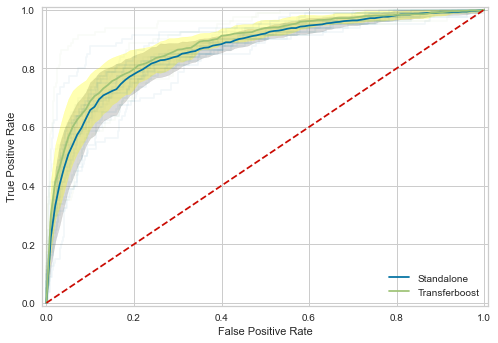

In [46]:
#Train TransferBoost model
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X, Y)
skf.get_n_splits(X1, Y1)
list_of_auc_TB = []
list_of_auc_standalone = [] 
list_of_auc_initialmodel = []
tprs = []
base_fpr = np.linspace(0, 1, 101)
tr_tprs = []
tr_base_fpr = np.linspace(0, 1, 101)

for train_index, test_index in skf.split(X1, Y1):
    
    seed = 424242
    test_size = 0.33
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=test_size, random_state=seed)
    
    model = xgboost.XGBClassifier(**{
    'learning_rate': 0.075,
    'max_depth': 5,
    'min_child_weight': 30,
    'n_estimators': 130,
    'reg_lambda': 100,
    'scale_pos_weight': 1,
    'subsample': 0.5})
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:,1]


    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_t, X_test_t = X1.iloc[train_index], X1.iloc[test_index]
    y_train_t, y_test_t = Y1.iloc[train_index], Y1.iloc[test_index]
    
 
    t_xgb_model = XGBTransferLearner(model)

    t_xgb_model.fit(X_train_t,y_train_t)

    y_pred_t = t_xgb_model.predict_proba(X_test_t)
    y_pred_t = [i[1] for i in y_pred_t ]

    model_standalone = xgboost.XGBClassifier(**{
        'learning_rate': 0.075,
        'max_depth': 5,
        'min_child_weight': 30,
        'n_estimators': 130,
        'reg_lambda': 100,
        'scale_pos_weight': 1,
        'subsample': 0.5})
    
    model_standalone.fit(X_train_t, y_train_t)
    
    y_pred_st = model_standalone.predict_proba(X_test_t)[:,1]
    #AUC SCORES XGBoost
    #Score with initial model
    auc_inputmodel = roc_auc_score(y_test, y_pred)

    #Score with transferlearning
    auc_transferboost = roc_auc_score(y_test_t, y_pred_t)

    #Score without transferlearning
    auc_standalone = roc_auc_score(y_test_t, y_pred_st)
    
    print("AUC Initial Model = ", auc_inputmodel)
    list_of_auc_initialmodel.append(auc_inputmodel) 
    print("AUC transferboost = ", auc_transferboost)
    list_of_auc_TB.append(auc_transferboost)
    print("AUC standalone = ", auc_standalone)
    list_of_auc_standalone.append(auc_standalone)
    
    fpr, tpr, _ = roc_curve(y_test_t, y_pred_st)
    tr_fpr, tr_tpr, _ = roc_curve(y_test_t, y_pred_t)
    
    plt.plot(fpr, tpr, 'b', alpha=0.05)
    plt.plot(tr_fpr, tr_tpr, 'g', alpha=0.05)
    
    tpr = interp(base_fpr, fpr, tpr)
    tr_tpr = interp(tr_base_fpr, tr_fpr, tr_tpr)
    
    tpr[0] = 0.0
    tr_tpr[0] = 0.0
    
    tr_tprs.append(tr_tpr)
    tprs.append(tpr)
    
    
print("Mean AUC Initial:", sum(list_of_auc_initialmodel) / len(list_of_auc_initialmodel), "Std Dev TB:", statistics.stdev(list_of_auc_initialmodel))         
print("Mean AUC TB:", sum(list_of_auc_TB) / len(list_of_auc_TB), "Std Dev TB:", statistics.stdev(list_of_auc_TB))
print("Mean AUC Standalone:", sum(list_of_auc_standalone) / len(list_of_auc_standalone), "Std Dev Standalone:", statistics.stdev(list_of_auc_standalone))

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

tr_tprs = np.array(tr_tprs)
mean_tr_tprs = tr_tprs.mean(axis=0)
tr_std = tr_tprs.std(axis=0)

tr_tprs_upper = np.minimum(mean_tr_tprs + tr_std, 1)
tr_tprs_lower = mean_tr_tprs - tr_std


plt.plot(base_fpr, mean_tprs, 'b', label='Standalone')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot(tr_base_fpr, mean_tr_tprs, 'g', label='Transferboost')
plt.fill_between(tr_base_fpr, tr_tprs_lower, tr_tprs_upper, color='yellow', alpha=0.3)


plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
pyplot.legend()
# plt.axes().set_aspect('equal', 'datalim')
plt.show()

In [47]:
mean_auc_tb = sum(list_of_auc_TB) / len(list_of_auc_TB)
mean_auc_standalone = sum(list_of_auc_standalone) / len(list_of_auc_standalone)

sum((a - mean_auc_tb) * (b - mean_auc_standalone) for (a,b) in zip(list_of_auc_TB,list_of_auc_standalone)) / len(list_of_auc_standalone)

0.0010742137061121337